# Question 5: The West Coast Heat Wave, Figure 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [3]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

In [4]:
data = ds.analysed_sst.sel(time = slice('2002', '2016'))

### Calculating 5-day Running Average Climatology (from years 2002 - 2012)

According to section 2.1 in the paper, both a 5-day and 30-day running average were used to calculate average climatology for each grid point. It's not totally clear which was used for the plots, so I implemented both, as well as a simplified implementation with no smoothing done.

In [5]:
trend_data = ds.analysed_sst.sel(time = slice('2002', '2012'))

In [6]:
# choose smoothing method for calculating climatology by uncommenting the line and commenting out the rest

# smoothing = 'none'
smoothing = '5 day running average'
# smoothing = '30 day running average'

In [7]:
match smoothing:
    case 'none':
        climatology = trend_data.groupby("time.dayofyear").mean(skipna=True)
    case '5 day running average':
        trend_5d = trend_data.rolling(time=5).mean(skipna=True)
        climatology = trend_5d.groupby('time.dayofyear').mean(skipna=True)
        del trend_5d
    case '30 day running average':
        trend_30d = trend_data.rolling(time=30).mean(skipna=True)
        climatology = trend_30d.groupby('time.dayofyear').mean(skipna=True)
        del trend_30d

In [8]:
# recover some memory from variables we don't need to use anymore
del ds
del trend_data

### Calculate Anomalies from Climatology

In [9]:
anomalies = data.groupby('time.dayofyear') - climatology

In [10]:
# recover some memory from variables we don't need to use anymore
del data
del climatology

### Figure 2a

#### Maximum 5 day average SST

Since we don't have enough memory to do this calculation all at once, we separate it into 3 separate jobs, then take the maximum of the final result. It is almost unnecessary to run the 2002-2012 parts, since the majority of the highest anomalies occurred between 2012 and 2016 anyways.

In [11]:
peak_anomalies = xr.concat(
    [
        anomalies.sel(time=slice('2002', '2007')).rolling(time=5).mean(skipna=True),
        anomalies.sel(time=slice('2007', '2012')).rolling(time=5).mean(skipna=True),
        anomalies.sel(time=slice('2012', '2016')).rolling(time=5).mean(skipna=True),
    ],
    dim='time'
).max(dim='time')

#### Plot

In [12]:
def annotate_map(ax, letter):
    """
    Helper function for adding latitude/longitude ticks,
    land lines, and subplot letter label to map.
    """
    # add lat/lon axis ticks
    ax.set_yticks([34, 38, 42, 46], crs=crs)
    ax.set_ylabel(None)
    ax.set_xticks([-130, -126, -122], crs=crs)
    ax.set_xticklabels(['130W', '126W', '122W'])
    ax.set_xlabel(None)

    # add land & coastlines
    ax.coastlines("10m", color="k")
    ax.add_feature(cfeature.LAND, color="grey")
    ax.add_feature(cfeature.STATES.with_scale("10m"))
    
    # add subplot letter label in the top right
    ax.text(-118.5, 48, letter, c='white', size='xx-large',
            weight=600, ha='right', va='top')

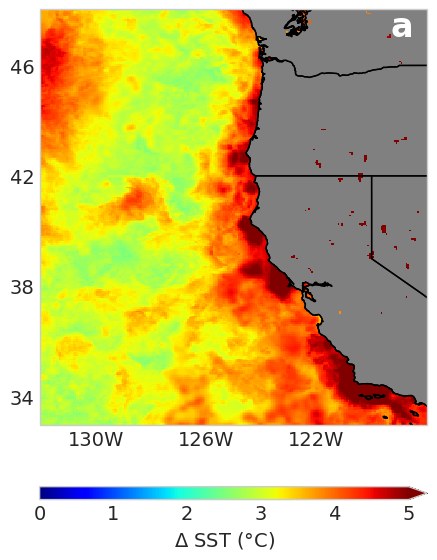

In [13]:
def fig2a(ax):
    # colorbar customization
    cbar_kwargs = {
        'location': 'bottom',
        'orientation': 'horizontal',
        'pad': 0.1,
        'aspect': 30,
        'label': '$\Delta$ SST ($\degree$C)',
        'ticks': np.arange(6),
    }

    peak_anomalies.plot(ax=ax, transform=crs, cmap='jet',
                        cbar_kwargs=cbar_kwargs,
                        vmin=0, vmax=5
    )

    annotate_map(ax, letter='a')

fig = plt.figure(figsize=(5, 8))
ax = plt.subplot(projection=crs)
fig2a(ax)
fig.savefig("outputs/Q05a.png", bbox_inches="tight")

### Figure 2b

In [14]:
# find which month the greatest anomaly occured in, for each grid point
peak_month = anomalies.idxmax(dim='time', skipna=True).dt.month

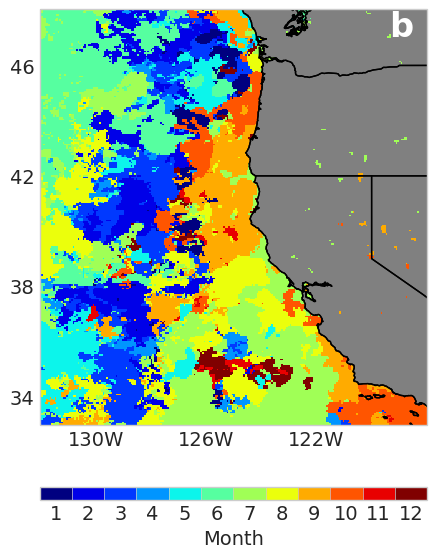

In [15]:
def fig2b(ax):
    # colorbar customization
    cbar_kwargs = {
        'location': 'bottom',
        'orientation': 'horizontal',
        'pad': 0.1,
        'aspect': 30,
        'label': 'Month',
        'ticks': np.arange(13),
        'drawedges': True,
        'boundaries': np.arange(0.5,13.5)
    }

    peak_month.plot(ax=ax, transform=crs, cmap='jet',
                    cbar_kwargs=cbar_kwargs
    )

    annotate_map(ax, letter='b')

fig = plt.figure(figsize=(5, 8))
ax = plt.subplot(projection=crs)
fig2b(ax)
fig.savefig("outputs/Q05b.png", bbox_inches="tight")

### Figure 2c

In [16]:
peak_year = anomalies.idxmax(dim='time', skipna=True).dt.year

# replace years before 2012 with NaN
peak_year = peak_year.where(peak_year >= 2013, np.nan)

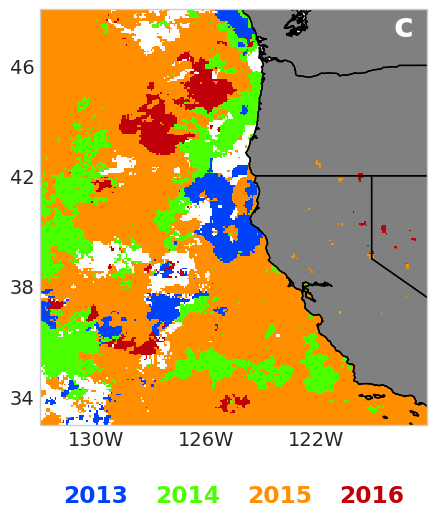

In [17]:
def fig2c(ax):
    # use same color levels as the paper
    colors = ['#0041FA', '#4BFF01', '#FF8E00', '#C00008']
    
    cbar_kwargs = {
        'location': 'bottom',
        'orientation': 'horizontal',
        'pad': 0.1,
        'aspect': 1
    }

    fig = peak_year.plot(ax=ax, transform=crs,
                         cbar_kwargs=cbar_kwargs,
                         levels=np.arange(2013, 2018), colors=colors)

    annotate_map(ax, letter='c')

    # hiding the colorbar instead of just removing it
    # ensures that this subplot lines up with the others
    fig.colorbar.ax.set_visible(False)
    
    # add colored years below plot
    for yr, col, x in zip(np.arange(2013,2017), colors, np.linspace(-130, -120, num=4)):
        ax.text(x, 30, yr, c=col, size='large', weight=550, ha='center', va='bottom');

fig = plt.figure(figsize=(5, 8))
ax = plt.subplot(projection=crs)
fig2c(ax)
fig.savefig("outputs/Q05c.png", bbox_inches="tight")

### Combined Figures

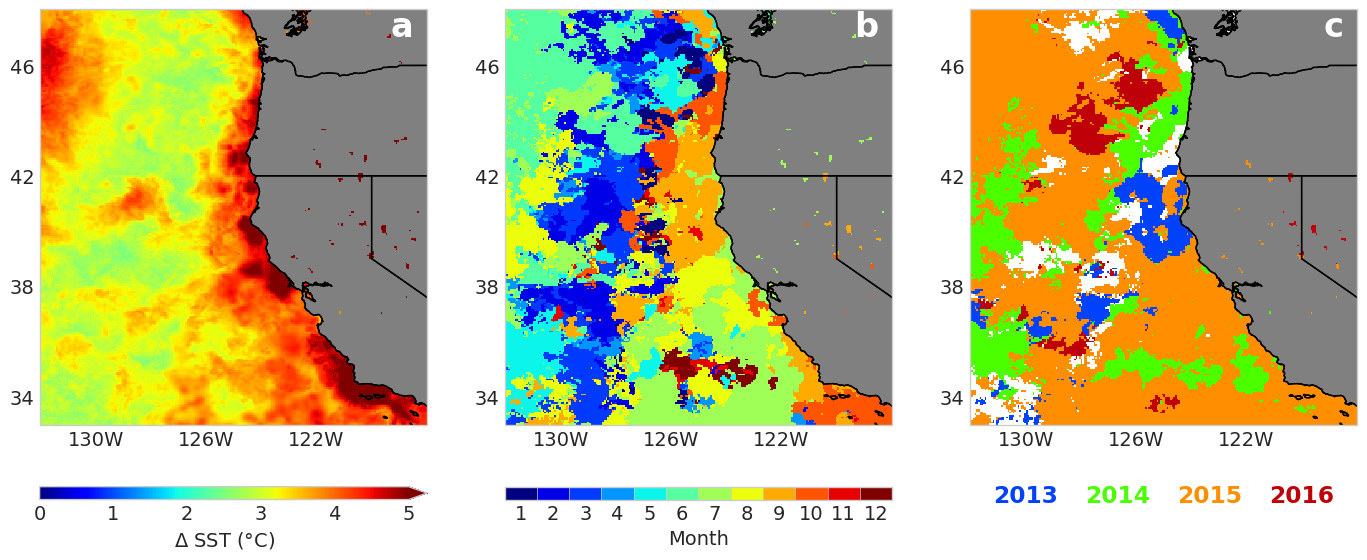

In [18]:
fig = plt.figure(figsize=(17, 8))
fig2a(plt.subplot(1, 3, 1, projection=crs))
fig2b(plt.subplot(1, 3, 2, projection=crs))
fig2c(plt.subplot(1, 3, 3, projection=crs))
fig.savefig("outputs/Q05.png", bbox_inches="tight")